# python-can CAN over serial

[```python-can```](https://python-can.readthedocs.io/en/2.1.0/index.html) includes a [CAN over Serial] module.

This allows prototyping and testing with inexpensive Arduino devices before switching to another module with minimal code changes.


The packet over serial



https://python-can.readthedocs.io/en/2.1.0/interfaces/serial.html

|                | Length (Byte) | Data type               | Byte order    | Description                                   |
|----------------|---------------|-------------------------|---------------|-----------------------------------------------|
| Start of frame | 1             | Byte                    | -             | Must be 0xAA                                  |
| Timestamp      | 4             | Unsigned 4 byte integer | Little-Endian | Usually s, ms or µs since start of the device |
| DLC            | 1             | Unsigned 1 byte integer | Little-Endian | Length in byte of the payload                 |
| Arbitration ID | 4             | Unsigned 4 byte integer | Little-Endian | -                                             |
| Payload        | 0 - 8         | Byte                    | -             | -                                             |
| End of frame   | 1             | Byte                    | -             | Must be 0xBB                                  |

In [1]:
import glob

In [2]:
old_sketches = glob.glob("*.ino")
old_sketches

['4747990f-b2a9-4145-93c3-5904a2402cde.ino']

In [3]:
import os

In [4]:
for old_sketch in old_sketches:
    os.unlink(old_sketch)

In [5]:
import uuid
build_uuid = str(uuid.uuid4())
build_uuid

'6670f1f1-8948-44e6-8a7b-ea590e54daf9'

In [6]:
arduino_template_str = """
unsigned long BAUD = {{ baud }};
unsigned long DELAY = {{ delay }};
char ARBITRATION_ID = {{ arbitration_id }};

char BUILD_UUID[] = "{{ build_uuid }}";

unsigned long time;

unsigned char counter = 0;

// Arduino Setup
void setup() {
  Serial.begin(BAUD);
  Serial.print("Build UUID: ");
  Serial.println(BUILD_UUID);
    // Start of frame
  Serial.write(0xAA);
// Timestamp
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);
// DLC
  Serial.write(0x01);
// Arbitration ID
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0xFF);
// Payload
  Serial.write(counter);
// End of frame
  Serial.write(0xBB);
    
  counter++;
}

// Arduino Main Loop
void loop() {
   time = millis();
// Start of frame
  Serial.write(0xAA);
// Timestamp
for(char shift=0;shift<32;shift+=8) {
  Serial.write((unsigned long)time>>shift&0b11111111);
}
// DLC
  Serial.write(0x01);
// Arbitration ID
for(char shift=0;shift<32;shift+=8) {
  Serial.write(((unsigned long)ARBITRATION_ID>>shift)&0b11111111);
}
// Payload
  Serial.write(counter);
// End of frame
  Serial.write(0xBB);
  counter++;
  delay(DELAY);
}
"""

In [7]:
import jinja2

In [8]:
arduino_template = jinja2.Template(arduino_template_str)

In [9]:
sketch_cfg=dict()
sketch_cfg["baud"] = 115200
sketch_cfg["delay"]= 1000
sketch_cfg["arbitration_id"]=12
sketch_cfg["build_uuid"]=build_uuid

arduino_sketch = (arduino_template.render(**sketch_cfg))

print(arduino_sketch)
with open(build_uuid+".ino", "w") as fid:
    fid.write(arduino_sketch)


unsigned long BAUD = 115200;
unsigned long DELAY = 1000;
char ARBITRATION_ID = 12;

char BUILD_UUID[] = "6670f1f1-8948-44e6-8a7b-ea590e54daf9";

unsigned long time;

unsigned char counter = 0;

// Arduino Setup
void setup() {
  Serial.begin(BAUD);
  Serial.print("Build UUID: ");
  Serial.println(BUILD_UUID);
    // Start of frame
  Serial.write(0xAA);
// Timestamp
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);
// DLC
  Serial.write(0x01);
// Arbitration ID
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0x00);
  Serial.write(0xFF);
// Payload
  Serial.write(counter);
// End of frame
  Serial.write(0xBB);
    
  counter++;
}

// Arduino Main Loop
void loop() {
   time = millis();
// Start of frame
  Serial.write(0xAA);
// Timestamp
for(char shift=0;shift<32;shift+=8) {
  Serial.write((unsigned long)time>>shift&0b11111111);
}
// DLC
  Serial.write(0x01);
// Arbitration ID
for(char shift=0;shift<32;shift+=8) {
  Serial.write(((unsigned 

In [10]:
import subprocess
stdout = subprocess.check_output(["make", "upload"]).decode()
import re
r = re.compile("(/dev/ttyUSB[\d]+)")
r.findall(stdout)
print(stdout)

-------------------------
Arduino.mk Configuration:
- [AUTODETECTED]       CURRENT_OS = LINUX 
- [AUTODETECTED]       ARDUINO_DIR = /usr/share/arduino 
- [COMPUTED]           ARDMK_DIR = /projects/arduino_IO/arduino_make (relative to Common.mk)
- [AUTODETECTED]       ARDUINO_VERSION = 105 
- [DEFAULT]            ARCHITECTURE =  
- [DEFAULT]            ARDMK_VENDOR = arduino 
- [AUTODETECTED]       ARDUINO_PREFERENCES_PATH = /mnt/ubuntu1604_2/home/jed/.arduino/preferences.txt 
- [AUTODETECTED]       ARDUINO_SKETCHBOOK = /mnt/ubuntu1604_2/home/jed/sketchbook (from arduino preferences file)
- [BUNDLED]            AVR_TOOLS_DIR = /usr/share/arduino/hardware/tools/avr (in Arduino distribution)
- [COMPUTED]           ARDUINO_LIB_PATH = /usr/share/arduino/libraries (from ARDUINO_DIR)
- [COMPUTED]           ARDUINO_VAR_PATH = /usr/share/arduino/hardware/arduino//variants (from ARDUINO_DIR)
- [COMPUTED]           BOARDS_TXT = /usr/share/arduino/hardware/arduino//boards.txt (from ARDUINO_DIR)
- 

In [11]:
serial_port = r.findall(stdout)
serial_port

['/dev/ttyUSB1', '/dev/ttyUSB1', '/dev/ttyUSB1']

In [12]:
import serial

In [13]:
ser = serial.Serial(port=serial_port[0], baudrate=115200, timeout=10)

In [14]:
import time

In [15]:
ser.setDTR(False) # Drop DTR
time.sleep(0.5)   # Read somewhere that 22ms is what the UI does.
ser.flushInput()
ser.setDTR(True)  # UP the DTR back
header = ser.readline()
header

b'Build UUID: 6670f1f1-8948-44e6-8a7b-ea590e54daf9\r\n'

In [16]:
header_uuid = header.decode("UTF-8").split(":")[1].strip()

In [17]:
assert build_uuid == header_uuid

In [18]:
ser.setDTR(False) # Drop DTR
time.sleep(0.5)   # Read somewhere that 22ms is what the UI does.
ser.flushInput()
ser.setDTR(True)  # UP the DTR back

header_packet = ser.read_until(b"\xBB")
header_packet

b'Build UUID: 6670f1f1-8948-44e6-8a7b-ea590e54daf9\r\n\xaa\x00\x00\x00\x00\x01\x00\x00\x00\xff\x00\xbb'

In [19]:
header_packet.split(b"\xAA")

[b'Build UUID: 6670f1f1-8948-44e6-8a7b-ea590e54daf9\r\n',
 b'\x00\x00\x00\x00\x01\x00\x00\x00\xff\x00\xbb']

In [20]:
packet = ser.read_until(b"\xBB")
packet

b'\xaa\x00\x00\x00\x00\x01\x0c\x00\x00\x00\x01\xbb'

In [21]:
packet = ser.read_until(b"\xBB")
packet

b'\xaa\xe8\x03\x00\x00\x01\x0c\x00\x00\x00\x02\xbb'

In [22]:
packet = ser.read_until(b"\xBB")
packet

b'\xaa\xd0\x07\x00\x00\x01\x0c\x00\x00\x00\x03\xbb'

In [23]:
packet[1:5]

b'\xd0\x07\x00\x00'

In [24]:
timestamp_raw = packet[1:5]
timestamp_raw

b'\xd0\x07\x00\x00'

In [25]:
int.from_bytes(timestamp_raw, 'little')

2000

In [26]:
int.from_bytes(timestamp_raw, 'big')

3490119680

In [27]:
timestamp = int.from_bytes(timestamp_raw, 'little')
timestamp

2000

In [28]:
sof = packet[0]
sof

170

In [29]:
int.from_bytes(b'\xAA', 'little')

170

In [30]:
int.from_bytes(b'\xAA', 'big')

170

In [31]:
assert sof == int.from_bytes(b'\xAA', 'little')

In [32]:
dlc = packet[5]
dlc

1

In [33]:
arbitration_id_raw = packet[6:10]
arbitration_id_raw

b'\x0c\x00\x00\x00'

In [34]:
int.from_bytes(arbitration_id_raw, 'little')

12

In [35]:
int.from_bytes(arbitration_id_raw, 'big')

201326592

In [36]:
arbitration_id = int.from_bytes(arbitration_id_raw, 'little')
arbitration_id

12

In [37]:
data = packet[11]
data 

187

In [38]:
sketch_cfg

{'baud': 115200,
 'delay': 1000,
 'arbitration_id': 12,
 'build_uuid': '6670f1f1-8948-44e6-8a7b-ea590e54daf9'}

In [39]:
assert arbitration_id == sketch_cfg["arbitration_id"]

In [40]:
header_uuid

'6670f1f1-8948-44e6-8a7b-ea590e54daf9'

In [41]:
sketch_cfg["build_uuid"]

'6670f1f1-8948-44e6-8a7b-ea590e54daf9'

In [42]:
assert str(header_uuid) == header_uuid

In [43]:
assert str(sketch_cfg["build_uuid"]) == sketch_cfg["build_uuid"]

In [44]:
assert header_uuid == sketch_cfg["build_uuid"]

In [45]:
ser.close()

In [55]:
import can
can.__version__

'2.1.0'

In [56]:
bus_cfg = dict()
bus_cfg["bustype"] = "serial"
bus_cfg["channel"]="/dev/ttyUSB1"
bus_cfg["bitrate"]=115200

bus = can.interface.Bus(**bus_cfg)    

In [57]:
bus.channel_info

'Serial interface: /dev/ttyUSB1'

In [58]:
packet = bus.recv(timeout=2)
packet

can.Message(timestamp=11.001, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xc, dlc=1, data=[0xc])

In [60]:
packet.arbitration_id

12

In [61]:
packet.dlc

1

In [62]:
packet.data

bytearray(b'\x0c')

In [63]:
int.from_bytes(packet.data, 'little')

12

In [64]:
int.from_bytes(packet.data, 'big')

12

In [65]:
import time

In [66]:
can_packets = list()
while len(can_packets)<20:
    packet = bus.recv(timeout=1000)
    if packet is None:
        time.sleep(sketch_cfg['delay'])
    can_packets.append(packet)

In [67]:
can_packets

[can.Message(timestamp=12.002, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xc, dlc=1, data=[0xd]),
 can.Message(timestamp=13.001, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xc, dlc=1, data=[0xe]),
 can.Message(timestamp=14.002, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xc, dlc=1, data=[0xf]),
 can.Message(timestamp=15.002, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xc, dlc=1, data=[0x10]),
 can.Message(timestamp=16.003, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xc, dlc=1, data=[0x11]),
 can.Message(timestamp=17.002, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xc, dlc=1, data=[0x12]),
 can.Message(timestamp=18.002, is_remote_frame=False, extended_id=True, is_error_frame=False, arbitration_id=0xc, dlc=1, data=[0x13]),
 can.Message(timestamp=19.003, is_remote_frame=False, exte

In [68]:
import numpy as np

In [70]:
data=object()

In [71]:
class Data(object):
    def __init__(self):
        pass
data = Data()

In [72]:
data.time = [packet.timestamp for packet in can_packets]
data.time

[12.002,
 13.001,
 14.002,
 15.002,
 16.003,
 17.002,
 18.002,
 19.003,
 20.002,
 21.003,
 22.003,
 23.004,
 24.003,
 25.004,
 26.004,
 27.003,
 28.004,
 29.004,
 30.004,
 31.004]

In [73]:
data.value = [int.from_bytes(packet.data, 'little') for packet in can_packets]

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

In [75]:
%matplotlib inline

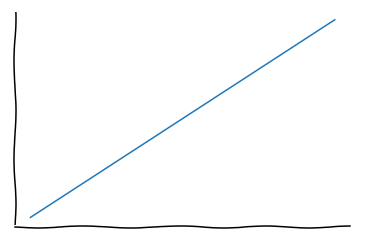

In [78]:
plt.xkcd()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xticks([])
plt.yticks([])
plt.plot(data.time, data.value)

In [ ]:
float.fromhex()